# MAGCOM算法仿真实验

# 依赖包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from copy import deepcopy
import random

# 轨迹生成

In [ ]:
class GenTrajectory:
    def __init__(self):
        pass

    def gen_multi_trajectory_patch(self, x: int, y: int, heading: int, mode: int) -> np.ndarray:
        """生成不同类型的样例轨迹
        :param mode: 不同类型的生成方法
            :1代表普通的直线生成, 确定起始点和航线
            :2代表随机的折线生成
        """
        profile, x_pos_list, y_pos_list = [], [], []
        if mode == 1:

            rad = np.deg2rad(heading)
            dx = np.cos(rad)
            dy = -np.sin(rad)
            
            for i in range(self.window_length):
                xi = int(round(x + i * dx))
                yi = int(round(y + i * dy))
                if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                    profile.append(self.reference_map[xi, yi])
                    x_pos_list.append(xi)
                    y_pos_list.append(yi)
                else:
                    profile.append(np.nan)
                    x_pos_list.append(np.nan)
                    y_pos_list.append(np.nan)
        elif mode == 2:
            k = 4
            for epoch in range(k):
                rad = np.deg2rad(heading)+random.random()*3.14
                dx = np.cos(rad)
                dy = -np.sin(rad)
                for i in range(self.window_length//k):
                    xi = int(round(x + i * dx))
                    yi = int(round(y + i * dy))
                    if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                        profile.append(self.reference_map[xi, yi])
                        x_pos_list.append(xi)
                        y_pos_list.append(yi)
                    else:
                        profile.append(np.nan)
                        x_pos_list.append(np.nan)
                        y_pos_list.append(np.nan) 
                x = xi
                y = yi
            
        else:
            print("Generating Trajectory Patch Failed, please check the mode index.")
            return 
        
        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

# 模版匹配类定义

## MAGCOM

In [2]:
class MAGCOMTerrainMatcher:
    """
    MA-GCOM (Moving Average - Generalized Correlation Matching) based terrain matching algorithm.
    This class implements a simplified MA-GCOM approach for matching measured terrain profile with a reference map.
    """

    def __init__(self, reference_map: np.ndarray, window_size: int = 10):
        """
        :param reference_map: 2D numpy array representing the reference terrain map (e.g., from DEM).
        :param window_size: Size of the matching window (sliding window) used in the algorithm.
        """
        self.reference_map = reference_map
        self.window_size = window_size

    def moving_average(self, data: np.ndarray) -> np.ndarray:
        """Applies a 2D moving average to smooth the data."""
        return gaussian_filter(data, sigma=1)

    def match(self, measured_profile: np.ndarray) -> tuple:
        """
        Match the measured profile against the reference map using generalized correlation.
        :param measured_profile: 2D terrain profile measured (e.g., by multi-beam).
        :return: Best match coordinates (x, y) in the reference map.
        """
        ref_map_smoothed = self.moving_average(self.reference_map)
        profile_smoothed = self.moving_average(measured_profile)

        h, w = profile_smoothed.shape
        H, W = ref_map_smoothed.shape

        best_score = -np.inf
        best_coords = (0, 0)

        for i in range(H - h):
            for j in range(W - w):
                window = ref_map_smoothed[i:i + h, j:j + w]
                score = self.generalized_correlation(window, profile_smoothed)
                if score > best_score:
                    best_score = score
                    best_coords = (i, j)

        return best_coords

    @staticmethod
    def generalized_correlation(a: np.ndarray, b: np.ndarray) -> float:
        """Computes normalized cross-correlation between two 2D arrays."""
        a_mean = a - np.mean(a)
        b_mean = b - np.mean(b)
        numerator = np.sum(a_mean * b_mean)
        denominator = np.sqrt(np.sum(a_mean ** 2) * np.sum(b_mean ** 2))
        return numerator / denominator if denominator != 0 else 0
    

class TrajectoryBasedTerrainMatcher(MAGCOMTerrainMatcher):
    """
    在基础模版匹配类的基础上定义子类，用于实现载体轨迹模版匹配算法。
    """
    
    def __init__(self, reference_map: np.ndarray, window_length: int = 10, resolution: float = 1.0):
        super().__init__(reference_map, window_size=window_length)
        self.window_length = window_length
        self.resolution = resolution
        
    
    def gen_multi_trajectory_patch(self, x: int, y: int, heading: int, mode: int) -> np.ndarray:
        """生成不同类型的样例轨迹
        :param mode: 不同类型的生成方法
            :1代表普通的直线生成, 确定起始点和航线
            :2代表随机的折线生成
        """
        profile, x_pos_list, y_pos_list = [], [], []
        if mode == 1:

            rad = np.deg2rad(heading)
            dx = np.cos(rad)
            dy = -np.sin(rad)
            
            for i in range(self.window_length):
                xi = int(round(x + i * dx))
                yi = int(round(y + i * dy))
                if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                    profile.append(self.reference_map[xi, yi])
                    x_pos_list.append(xi)
                    y_pos_list.append(yi)
                else:
                    profile.append(np.nan)
                    x_pos_list.append(np.nan)
                    y_pos_list.append(np.nan)
        elif mode == 2:
            k = 4
            for epoch in range(k):
                rad = np.deg2rad(heading)+random.random()*3.14
                dx = np.cos(rad)
                dy = -np.sin(rad)
                for i in range(self.window_length//k):
                    xi = int(round(x + i * dx))
                    yi = int(round(y + i * dy))
                    if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                        profile.append(self.reference_map[xi, yi])
                        x_pos_list.append(xi)
                        y_pos_list.append(yi)
                    else:
                        profile.append(np.nan)
                        x_pos_list.append(np.nan)
                        y_pos_list.append(np.nan) 
                x = xi
                y = yi
            
        else:
            print("Generating Trajectory Patch Failed, please check the mode index.")
            return 
        
        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

    def extract_trajectory_patch(self, x: int, y: int, heading: float) -> np.ndarray:
        """通过航向确定轨迹"""
        rad = np.deg2rad(heading)
        dx = np.cos(rad)
        dy = -np.sin(rad)

        profile = []
        x_pos_list, y_pos_list = [], []
        for i in range(self.window_length):
            xi = int(round(x + i * dx))
            yi = int(round(y + i * dy))
            if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                profile.append(self.reference_map[xi, yi])
                x_pos_list.append(xi)
                y_pos_list.append(yi)
            else:
                profile.append(np.nan)
                x_pos_list.append(np.nan)
                y_pos_list.append(np.nan)

        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None
    
    def extract_trajectory_patch2(self, x, y, true_profile) -> np.ndarray:
        """参考样例位置序列确定待匹配序列的轨迹
        :param x&y:起始位置的x,y坐标
        :param true_profile: 样例数据, shape=(3, N),前两维指示x,y坐标序列,最后一维指示地形信息
        :return: 
        """
        delta_x = [i-true_profile[0, 0] for i in true_profile[0, :]]
        delta_y = [i-true_profile[1, 0] for i in true_profile[1, :]]

        profile = []
        x_pos_list, y_pos_list = [], []
        for i in range(self.window_length):
            xi = int(round(x + delta_x[i]))
            yi = int(round(y + delta_y[i]))
            if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                profile.append(self.reference_map[xi, yi])
                x_pos_list.append(xi)
                y_pos_list.append(yi)
            else:
                profile.append(np.nan)
                x_pos_list.append(np.nan)
                y_pos_list.append(np.nan)

        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

    def match_trajectory(self, measured_profile: np.ndarray, heading: float, gen_mode: int) -> tuple:
        """轨迹匹配
        :param gen_mode:代表生成待匹配轨迹方式,1表示通过航向确定,2表示参考样例位置序列确定
        """
        best_score = -np.inf
        best_candidate = None

        for x in range(self.reference_map.shape[0]):
            for y in range(self.reference_map.shape[1]):
                # 获取待匹配轨迹序列
                if gen_mode == 1:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                elif gen_mode == 2:
                    candidate = self.extract_trajectory_patch2(x, y, measured_profile)
                else:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                    
                if candidate is not None and len(candidate[2, :]) == len(measured_profile[2, :]):
                    score = self.generalized_correlation(candidate[2, :].reshape(1, -1),
                                                        measured_profile[2, :].reshape(1, -1))
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate

        return best_candidate


## ICCP算法

### v1:使用最小二乘法寻找最佳投影点

In [6]:
# ICCP implementation + demo
# This notebook implements the ICCP algorithm you described:
# - builds a 2D contour map (grid)
# - computes contour lines for many levels (matplotlib)
# - for each measurement point, finds a matching contour point:
#     * prefer nearest point on precomputed contour lines for the same level (or nearest level)
#     * fallback: use gradient-based projection (Newton-like) to move the point to the isocontour
# - computes optimal translation (mean of q - p') and iterates until convergence
#
# The demo generates a synthetic terrain with multiple Gaussian hills, simulates measurements
# taken along a path (with a true translation applied), adds noise, and recovers the translation.
#
# Notes:
# - Uses matplotlib to extract contour paths.
# - Uses scipy.spatial.cKDTree when available; otherwise falls back to numpy brute-force search.
# - Plots: contour map, measured points before/after correction, matched correspondences,
#   and translation norm per iteration.
#
# Run this cell to execute the demo and observe results.

import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.spatial import cKDTree as KDTree
    KD_AVAILABLE = True
except Exception:
    KD_AVAILABLE = False


def make_contour_map(xmin=-50, xmax=50, ymin=-50, ymax=50, nx=301, ny=301, seed=0):
    rng = np.random.RandomState(seed)
    xs = np.linspace(xmin, xmax, nx)
    ys = np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    centers = [(-20, -10), (10, -5), (15, 20), (-5, 25)]
    amps = [30, 20, 40, -25]
    sigmas = [8, 6, 10, 12]
    for c, a, s in zip(centers, amps, sigmas):
        Z += a * np.exp(-(((X-c[0])**2 + (Y-c[1])**2) / (2*s*s)))
    Z += 0.2 * X + 0.1 * Y + 3.0 * np.sin(0.15 * X) * np.cos(0.12 * Y)
    Z += 0.5 * rng.normal(size=Z.shape)
    return xs, ys, Z


def extract_contour_points(xs, ys, Z, levels_count=80):
    levels = np.linspace(np.min(Z), np.max(Z), levels_count)
    cs = plt.contour(xs, ys, Z, levels=levels)
    contour_points = {}
    for i, level in enumerate(cs.levels):
        pts = []
        coll = cs.collections[i]
        for path in coll.get_paths():
            v = path.vertices
            if v.size:
                pts.append(v)
        if pts:
            contour_points[level] = np.vstack(pts)
    plt.clf()
    return contour_points


def build_level_kdtrees(contour_points):
    kd = {}
    for level, pts in contour_points.items():
        if KD_AVAILABLE and pts.shape[0] > 0:
            kd[level] = KDTree(pts)
        else:
            kd[level] = pts
    return kd


def bilinear_interpolate(xs, ys, Z, xq, yq):
    xq = np.array(xq)
    yq = np.array(yq)
    dx = xs[1] - xs[0]
    dy = ys[1] - ys[0]
    ix = (xq - xs[0]) / dx
    iy = (yq - ys[0]) / dy
    ix0 = np.floor(ix).astype(int)
    iy0 = np.floor(iy).astype(int)
    ix0 = np.clip(ix0, 0, len(xs)-2)
    iy0 = np.clip(iy0, 0, len(ys)-2)
    tx = (ix - ix0)
    ty = (iy - iy0)
    z00 = Z[iy0, ix0]
    z10 = Z[iy0, ix0+1]
    z01 = Z[iy0+1, ix0]
    z11 = Z[iy0+1, ix0+1]
    z = (1-tx)*(1-ty)*z00 + tx*(1-ty)*z10 + (1-tx)*ty*z01 + tx*ty*z11
    return z


def interp_grad_from_precomputed(xs, ys, dz_dx, dz_dy, xq, yq):
    gx = bilinear_interpolate(xs, ys, dz_dx, xq, yq)
    gy = bilinear_interpolate(xs, ys, dz_dy, xq, yq)
    return gx, gy


def project_point_to_isocontour_gradient(xs, ys, Z, dz_dx, dz_dy, point, z_target, max_iter=20, tol=1e-3):
    q = np.array(point, dtype=float)
    for _ in range(max_iter):
        fval = bilinear_interpolate(xs, ys, Z, q[0], q[1])
        residual = z_target - fval
        if abs(residual) < tol:
            break
        gx, gy = interp_grad_from_precomputed(xs, ys, dz_dx, dz_dy, q[0], q[1])
        gnorm2 = gx*gx + gy*gy
        if gnorm2 < 1e-8:
            break
        step = np.array([gx, gy]) * (residual / gnorm2)
        q = q + step
    final_res = z_target - bilinear_interpolate(xs, ys, Z, q[0], q[1])
    return q, final_res


def find_nearest_contour_level(contour_points, desired_level):
    if len(contour_points)==0:
        return None
    levels = np.array(list(contour_points.keys()))
    idx = np.argmin(np.abs(levels - desired_level))
    return levels[idx]


def find_nearest_on_contour_kdtree_or_bruteforce(contour_points, kdtrees, level, point):
    if level not in contour_points:
        return None, np.inf
    pts = contour_points[level]
    if KD_AVAILABLE and isinstance(kdtrees.get(level, None), KDTree):
        d, idx = kdtrees[level].query(point)
        return pts[idx], d
    else:
        d2 = np.sum((pts - point)**2, axis=1)
        idx = np.argmin(d2)
        return pts[idx], np.sqrt(d2[idx])


def iccp(xs, ys, Z, P, T0=np.array([0.0,0.0]), eps=1e-3, max_iter=40, verbose=True):
    contour_points = extract_contour_points(xs, ys, Z, levels_count=100)
    kdtrees = build_level_kdtrees(contour_points)
    # Precompute gradients once
    dz_dy, dz_dx = np.gradient(Z, ys, xs)  # shape matches Z

    T = np.array(T0, dtype=float)
    history = [T.copy()]
    matched_history = []

    for k in range(max_iter):
        projected = P[:, :2] + T
        matched_q = np.zeros_like(projected)
        valid_mask = np.zeros(len(P), dtype=bool)
        for i, (pprime, zi) in enumerate(zip(projected, P[:,2])):
            if len(contour_points)==0:
                # fallback to gradient-only projection
                q, res = project_point_to_isocontour_gradient(xs, ys, Z, dz_dx, dz_dy, pprime, zi)
                matched_q[i] = q
                valid_mask[i] = True
                continue
            nearest_level = find_nearest_contour_level(contour_points, zi)
            q_candidate, d_candidate = find_nearest_on_contour_kdtree_or_bruteforce(contour_points, kdtrees, nearest_level, pprime)
            # Attempt gradient projection from pprime
            q_proj, res = project_point_to_isocontour_gradient(xs, ys, Z, dz_dx, dz_dy, pprime, zi, max_iter=12, tol=1e-3)
            if abs(res) < 5e-2:
                matched_q[i] = q_proj
                valid_mask[i] = True
            else:
                if q_candidate is not None:
                    matched_q[i] = q_candidate
                    valid_mask[i] = True
                else:
                    valid_mask[i] = False

        if np.sum(valid_mask) < 3:
            if verbose:
                print("Too few matches; stopping.")
            break

        q_valid = matched_q[valid_mask]
        pprime_valid = projected[valid_mask]
        deltaT = np.mean(q_valid - pprime_valid, axis=0)
        T = T + deltaT
        history.append(T.copy())
        matched_history.append((pprime_valid.copy(), q_valid.copy()))
        if verbose:
            print(f"Iter {k+1}: deltaT = {deltaT}, ||deltaT|| = {np.linalg.norm(deltaT):.6f}, matches = {len(q_valid)}")
        if np.linalg.norm(deltaT) < eps:
            if verbose:
                print("Converged.")
            break
    return T, np.array(history), matched_history

Iter 1: deltaT = [ 2.80176987 -3.04513906], ||deltaT|| = 4.137969, matches = 40
Iter 2: deltaT = [ 6.64060477 -1.27251725], ||deltaT|| = 6.761430, matches = 40
Iter 3: deltaT = [ 3.32772821 -1.86634062], ||deltaT|| = 3.815364, matches = 40
Iter 4: deltaT = [ 2.42293693 -0.54805415], ||deltaT|| = 2.484147, matches = 40
Iter 5: deltaT = [ 1.06409506 -0.0960131 ], ||deltaT|| = 1.068418, matches = 40
Iter 6: deltaT = [ 0.53574124 -0.21216958], ||deltaT|| = 0.576224, matches = 40
Iter 7: deltaT = [0.15051869 0.02114379], ||deltaT|| = 0.151997, matches = 40
Iter 8: deltaT = [ 0.28306464 -0.20425592], ||deltaT|| = 0.349065, matches = 40
Iter 9: deltaT = [ 0.13230999 -0.2465635 ], ||deltaT|| = 0.279820, matches = 40
Iter 10: deltaT = [ 0.0279734  -0.06578746], ||deltaT|| = 0.071488, matches = 40
Iter 11: deltaT = [-0.01180484  0.09724888], ||deltaT|| = 0.097963, matches = 40
Iter 12: deltaT = [-0.0710414  -0.00464861], ||deltaT|| = 0.071193, matches = 40
Iter 13: deltaT = [ 0.03454211 -0.01570

<Figure size 640x480 with 0 Axes>

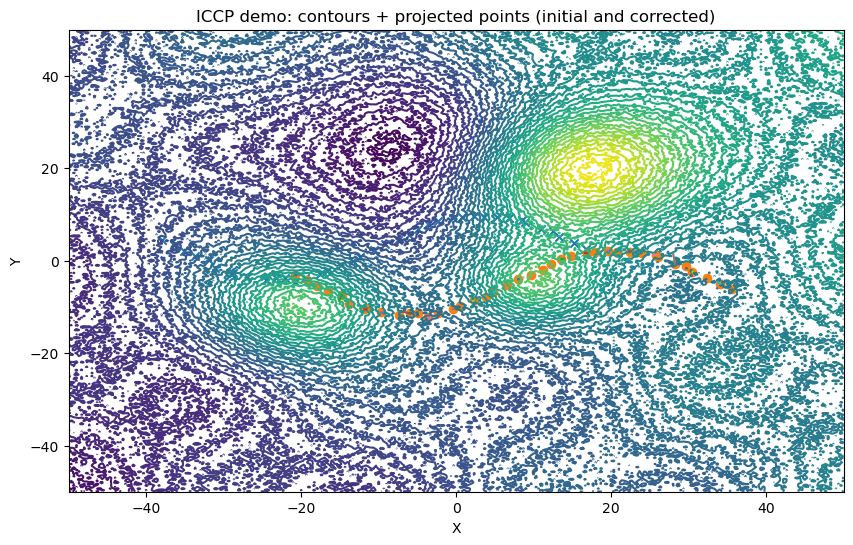

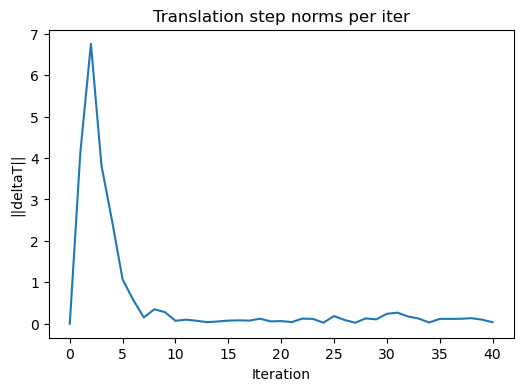

Translation history:
 Iter 0: T = [-10.0000, 3.0000]
 Iter 1: T = [-7.1982, -0.0451]
 Iter 2: T = [-0.5576, -1.3177]
 Iter 3: T = [2.7701, -3.1840]
 Iter 4: T = [5.1930, -3.7321]
 Iter 5: T = [6.2571, -3.8281]
 Iter 6: T = [6.7929, -4.0402]
 Iter 7: T = [6.9434, -4.0191]
 Iter 8: T = [7.2265, -4.2233]
 Iter 9: T = [7.3588, -4.4699]
 Iter 10: T = [7.3867, -4.5357]
 Iter 11: T = [7.3749, -4.4384]
 Iter 12: T = [7.3039, -4.4431]
 Iter 13: T = [7.3384, -4.4588]
 Iter 14: T = [7.3729, -4.4167]
 Iter 15: T = [7.2981, -4.4104]
 Iter 16: T = [7.3776, -4.4256]
 Iter 17: T = [7.3580, -4.4981]
 Iter 18: T = [7.2595, -4.5685]
 Iter 19: T = [7.2801, -4.5160]
 Iter 20: T = [7.2215, -4.4905]
 Iter 21: T = [7.2611, -4.4912]
 Iter 22: T = [7.3844, -4.4885]
 Iter 23: T = [7.3057, -4.5746]
 Iter 24: T = [7.3176, -4.5528]
 Iter 25: T = [7.4399, -4.4133]
 Iter 26: T = [7.3560, -4.4478]
 Iter 27: T = [7.3710, -4.4671]
 Iter 28: T = [7.4140, -4.5869]
 Iter 29: T = [7.3104, -4.5677]
 Iter 30: T = [7.5499, -4.

In [7]:
# Demo with fewer points for speed
xs, ys, Z = make_contour_map(nx=301, ny=301, seed=1)

# generate path and samples
t = np.linspace(-28, 28, 40)  # fewer points
true_path = np.vstack((t, 7.0*np.sin(0.12*t))).T
T_true = np.array([7.3, -4.7])
z_samples = bilinear_interpolate(xs, ys, Z, true_path[:,0] + T_true[0], true_path[:,1] + T_true[1])
z_noisy = z_samples + 0.4 * np.random.randn(len(z_samples))
pos_noisy = true_path + 0.3 * np.random.randn(*true_path.shape)
P = np.column_stack((pos_noisy, z_noisy))

T0 = np.array([-10.0, 3.0])
T_est, history, matched = iccp(xs, ys, Z, P, T0=T0, eps=1e-3, max_iter=40, verbose=True)

print("\nTrue translation:", T_true)
print("Initial guess:", T0)
print("Estimated translation:", T_est)
print("Error (est - true):", T_est - T_true)

# Plot results
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
levels = np.linspace(np.min(Z), np.max(Z), 40)
ax.contour(xs, ys, Z, levels=levels)
proj_initial = P[:,:2] + T0
proj_est = P[:,:2] + T_est
ax.scatter(proj_initial[:,0], proj_initial[:,1], marker='x')
ax.scatter(proj_est[:,0], proj_est[:,1], marker='o')
if len(matched)>0:
    pprime_valid, q_valid = matched[-1]
    for pp, qq in zip(pprime_valid[::2], q_valid[::2]):
        ax.plot([pp[0], qq[0]], [pp[1], qq[1]])
ax.set_title("ICCP demo: contours + projected points (initial and corrected)")
ax.set_xlabel("X"); ax.set_ylabel("Y")
plt.show()

fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot(1,1,1)
deltas = np.linalg.norm(np.diff(history, axis=0, prepend=history[0:1]), axis=1)
ax2.plot(np.arange(len(history)), deltas)
ax2.set_xlabel("Iteration"); ax2.set_ylabel("||deltaT||"); ax2.set_title("Translation step norms per iter")
plt.show()

print("Translation history:")
for i, h in enumerate(history):
    print(f" Iter {i}: T = [{h[0]:.4f}, {h[1]:.4f}]")


路径混乱问题，是 ICCP 优化中独立对每个点优化所导致的典型现象。

虽然每个点都尝试最小化自身的高程误差，但整体轨迹却变得不连贯、不平滑。

这个问题的核心原因在于：缺乏轨迹的时序和连续性约束。

### v1.1:平滑版本

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


class ICCPOptimizer:
    def __init__(self, dem_map, step_size=1.0, max_iters=100, lambda_smooth=1.0):
        self.dem_map = dem_map
        self.step_size = step_size
        self.max_iters = max_iters
        self.lambda_smooth = lambda_smooth
        self.map_height, self.map_width = dem_map.shape

    def extract_altitude(self, trajectory):
        altitudes = []
        for x, y in trajectory:
            xi, yi = int(round(x)), int(round(y))
            if 0 <= xi < self.map_height and 0 <= yi < self.map_width:
                altitudes.append(self.dem_map[xi, yi])
            else:
                altitudes.append(np.nan)
        return np.array(altitudes)

    def compute_smoothness_loss(self, traj):
        loss = 0.0
        for i in range(1, len(traj) - 1):
            loss += np.sum((traj[i - 1] - 2 * traj[i] + traj[i + 1]) ** 2)
        return loss / (len(traj) - 2)

    def compute_loss(self, measured, estimated, traj):
        valid = ~np.isnan(estimated)
        data_loss = np.mean((measured[valid] - estimated[valid]) ** 2) if np.any(valid) else np.inf
        smooth_loss = self.compute_smoothness_loss(traj)
        return data_loss + self.lambda_smooth * smooth_loss

    def optimize_trajectory(self, init_traj, measured_alt):
        traj = init_traj.copy()
        eps = .5  # 网格级扰动最合适
        for _ in range(self.max_iters):
            grad = np.zeros_like(traj)
            base_alt = self.extract_altitude(traj)
            base_loss = self.compute_loss(measured_alt, base_alt, traj)

            for i in range(len(traj)):
                for j in range(2):  # x 和 y
                    perturbed = traj.copy()
                    perturbed[i, j] += eps
                    # print(perturbed)
                    perturbed_alt = self.extract_altitude(perturbed)
                    perturbed_loss = self.compute_loss(measured_alt, perturbed_alt, perturbed)
                    grad[i, j] = (perturbed_loss - base_loss) / eps

            traj -= self.step_size * grad

        return traj


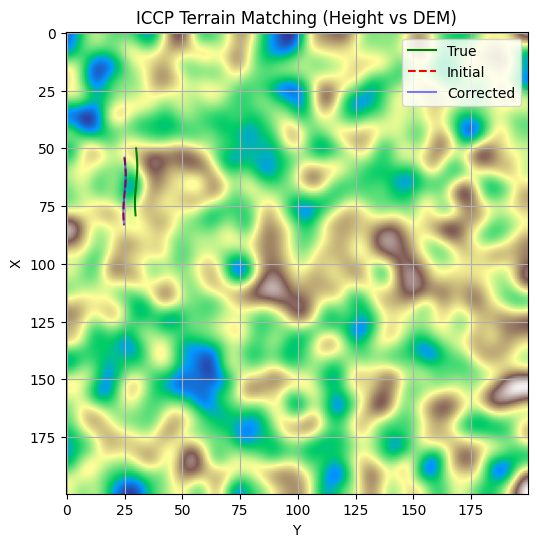

In [74]:

# ---------- 仿真数据生成 ----------
np.random.seed(42)
dem = gaussian_filter(np.random.rand(200, 200), sigma=5)
true_traj = np.array([[50 + i, 30 + 0.5 * np.sin(i / 5)] for i in range(30)])

def sample_dem(traj, dem):
    alt = []
    for x, y in traj:
        xi, yi = int(round(x)), int(round(y))
        alt.append(dem[xi, yi] if 0 <= xi < dem.shape[0] and 0 <= yi < dem.shape[1] else np.nan)
    return np.array(alt)

# measured_alt = sample_dem(true_traj, dem) + np.random.normal(0, 0.000001, len(true_traj))
measured_alt = sample_dem(true_traj, dem)
init_traj = true_traj + np.array([4.0, -5.0])

# ---------- 执行 ICCP 匹配 ----------
optimizer = ICCPOptimizer(dem, step_size=1, max_iters=10)
corrected_traj = optimizer.optimize_trajectory(init_traj, measured_alt)

# ---------- 可视化 ----------
plt.figure(figsize=(8, 6))
plt.imshow(dem, cmap='terrain')
plt.plot(true_traj[:, 1], true_traj[:, 0], 'g-', label='True')
plt.plot(init_traj[:, 1], init_traj[:, 0], 'r--', label='Initial')
plt.plot(corrected_traj[:, 1], corrected_traj[:, 0], 'b-', label='Corrected', alpha=0.5)
plt.legend()
plt.title("ICCP Terrain Matching (Height vs DEM)")
plt.xlabel("Y")
plt.ylabel("X")
plt.grid(True)
plt.show()


### v2:刚体变换

In [8]:
import numpy as np

class WeightedRigidRegistration2D:
    def __init__(self):
        pass

    def fit(self, P, Q, w=None):
        """
        对齐源点集P到目标点集Q。P,Q为(N,2)数组; w为长度N的权重数组(可选)。
        返回旋转矩阵R(2x2)、平移向量t(2,)和变换后的点阵P_transformed。
        """
        P = np.asarray(P, dtype=float)
        Q = np.asarray(Q, dtype=float)
        if P.shape != Q.shape:
            raise ValueError("点集维度不匹配")
        N = P.shape[0]
        if w is None:
            w = np.ones(N)  # 默认等权
        w = np.asarray(w, dtype=float).reshape(-1)
        W = w.sum()
        # 计算加权质心
        centroid_P = (w[:,None] * P).sum(axis=0) / W
        centroid_Q = (w[:,None] * Q).sum(axis=0) / W
        # 去中心化
        P_centered = P - centroid_P
        Q_centered = Q - centroid_Q

        """
        # 构造协方差矩阵H
        # H = sum_i w_i * (P_centered[i] 外积 Q_centered[i])
        H = (P_centered * w[:,None]).T.dot(Q_centered)
        # 解析法计算旋转角度
        # H = [[h11, h12],[h21,h22]]
        h11, h12 = H[0,0], H[0,1]
        h21, h22 = H[1,0], H[1,1]
        # 计算角度 theta
        a = h11 + h22  # = sum w*(x_i*x'_i + y_i*y'_i)
        b = h21 - h12  # = sum w*(x_i*y'_i - y_i*x'_i)
        theta = np.arctan2(b, a)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta),  np.cos(theta)]])
        # 确保det(R)=1（可以加上判断符号的步骤，2D一般无需调整）
        # 计算平移
        t = centroid_Q - R.dot(centroid_P)
        # 应用变换
        P_transformed = (R.dot(P.T)).T + t
        """
        # 加权协方差矩阵
        H = (P_centered * w[:, None]).T @ Q_centered
        # 使用 SVD 求解旋转
        U, _, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        # 反射修正
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        # 平移
        t = centroid_Q - R @ centroid_P
        # 应用变换
        P_transformed = (R @ P.T).T + t

        return R, t, P_transformed

True Rotation Matrix:
 [[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]
Estimated Rotation Matrix:
 [[ 0.82307313 -0.5679354 ]
 [ 0.5679354   0.82307313]]
True Translation Vector:
 [ 1.5 -2. ]
Estimated Translation Vector:
 [ 2.01010259 -2.05108428]
Alignment Error (RMSE): 0.3101982599208393


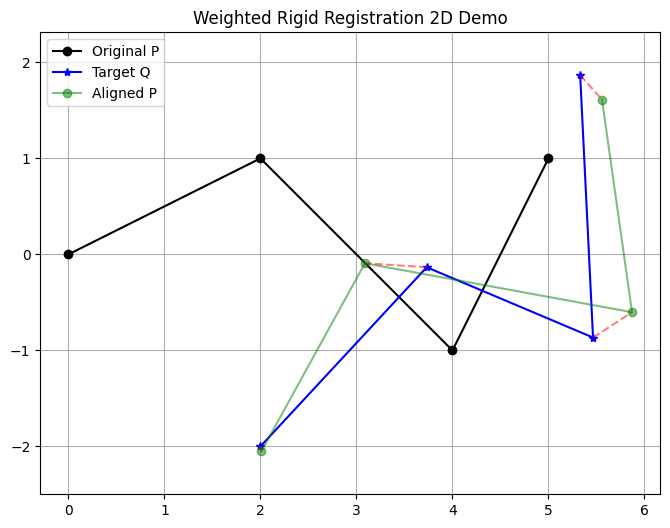

In [11]:
# --- Demo ---
if __name__ == "__main__":
    np.random.seed(42)

    # 1. 构造原始点集 P
    P = np.array([[0, 0], [2, 1], [4, -1], [5, 1]])

    # 2. 定义已知旋转角和平移向量
    theta_true = np.radians(30)  # 30度旋转
    t_true = np.array([1.5, -2.0])
    R_true = np.array([[np.cos(theta_true), -np.sin(theta_true)],
                       [np.sin(theta_true),  np.cos(theta_true)]])

    # 3. 应用变换生成目标点集 Q
    Q = (R_true @ P.T).T + t_true
    # 手动修改其中的坐标
    Q[0, 0] += 0.5
    Q[1, 0] += 1  
    Q[3, 1] += 0.5 

    # 4. 添加权重
    w = np.array([1.0, 1.0, 1.0, 1.0])  # 示例权重

    # 5. 执行配准
    reg = WeightedRigidRegistration2D()
    R_est, t_est, P_aligned = reg.fit(P, Q, w)

    # 6. 输出结果
    print("True Rotation Matrix:\n", R_true)
    print("Estimated Rotation Matrix:\n", R_est)
    print("True Translation Vector:\n", t_true)
    print("Estimated Translation Vector:\n", t_est)
    print("Alignment Error (RMSE):", np.sqrt(np.mean((P_aligned - Q) ** 2)))

    # 7. 可视化
    plt.figure(figsize=(8, 6))
    plt.plot(P[:, 0], P[:, 1], 'ko-', label='Original P')
    plt.plot(Q[:, 0], Q[:, 1], 'b*-', label='Target Q')
    plt.plot(P_aligned[:, 0], P_aligned[:, 1], 'go-', label='Aligned P', alpha=0.5)
    for i in range(P.shape[0]):
        plt.plot([Q[i, 0], P_aligned[i, 0]], [Q[i, 1], P_aligned[i, 1]], 'r--', alpha=0.5)
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.title("Weighted Rigid Registration 2D Demo")
    plt.show()

# 评估函数

In [4]:
def compute_rmse(true_coords, estimated_coords):
    """
    Computes RMSE between true and estimated coordinates.
    :param true_coords: Tuple (x, y) of the ground truth location.
    :param estimated_coords: Tuple (x, y) of the matched location.
    :return: RMSE value.
    """
    true = np.array(true_coords)
    estimated = np.array(estimated_coords)
    return np.sqrt(np.mean((true - estimated) ** 2))

def compute_mismatch_probability(reference_map, profile, true_coords, matcher, threshold=5):
    """
    Estimates the probability of mismatch by testing multiple noisy profiles.
    :param reference_map: The reference terrain map.
    :param profile: Original measured profile without noise.
    :param true_coords: Ground truth (x, y).
    :param matcher: An instance of the MAGCOMTerrainMatcher.
    :param threshold: Distance threshold beyond which a match is considered incorrect.
    :return: Mismatch rate.
    """
    num_trials = 50
    mismatches = 0

    for _ in range(num_trials):
        noisy_profile = profile + np.random.normal(0, 0.02, profile.shape)
        estimated_coords = matcher.match(noisy_profile)
        error = compute_rmse(true_coords, estimated_coords)
        if error > threshold:
            mismatches += 1

    return mismatches / num_trials


# 工具函数

# Demo

## MAGCOM

### 测试2D匹配

In [5]:
# Simulate a terrain map and measured terrain profile
np.random.seed(0)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
measured_x, measured_y = 40, 60
measured_profile = terrain_map[measured_x:measured_x + 10, measured_y:measured_y + 10] + np.random.normal(0, 0.01, (10, 10))

# Run MA-GCOM terrain matching
matcher = MAGCOMTerrainMatcher(reference_map=terrain_map, window_size=10)
matched_coords = matcher.match(measured_profile)

# Evaluate RMSE
rmse = compute_rmse((measured_x, measured_y), matched_coords)
print(f"RMSE between true and matched location: {rmse:.2f} pixels")

# Evaluate mismatch probability
mismatch_rate = compute_mismatch_probability(terrain_map, measured_profile, (measured_x, measured_y), matcher)
print(f"Estimated mismatch probability (error > 5 pixels): {mismatch_rate:.2%}")

RMSE between true and matched location: 0.00 pixels
Estimated mismatch probability (error > 5 pixels): 30.00%


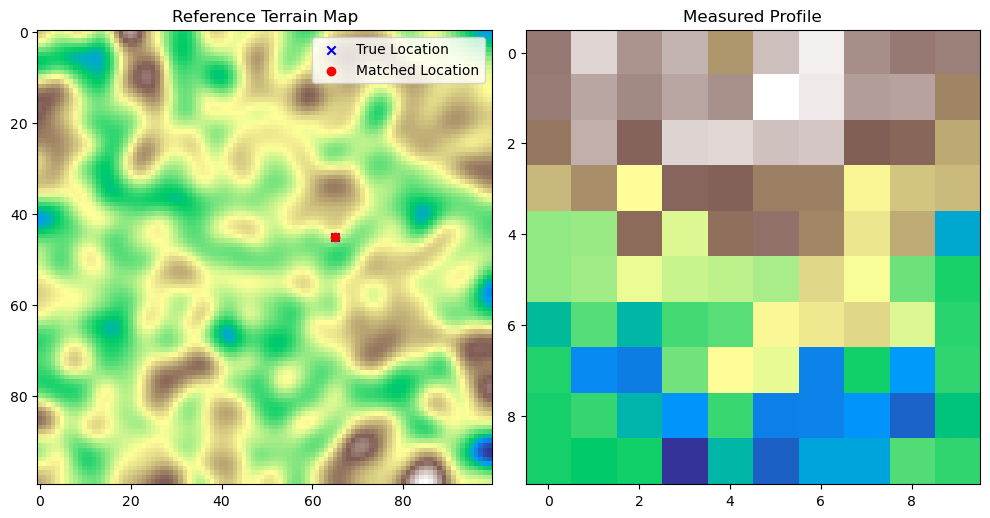

In [6]:
# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Reference Terrain Map")
plt.imshow(terrain_map, cmap='terrain')
plt.scatter(measured_y + 5, measured_x + 5, marker='x', color='blue', label='True Location')
plt.scatter(matched_coords[1] + 5, matched_coords[0] + 5, marker='o', color='red', label='Matched Location')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Measured Profile")
plt.imshow(measured_profile, cmap='terrain')

plt.tight_layout()
plt.show()

### 测试轨迹匹配

#### 用法一: 假定航向不变

In [36]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.extract_trajectory_patch(true_start_x, true_start_y, true_heading)

measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.008, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=1)
estimated_profile = matcher_traj.extract_trajectory_patch2(estimated_coords[0, 0], estimated_coords[1, 0], estimated_coords)

In [37]:
true_profile[2, :]

array([0.51169671, 0.50386602, 0.50386602, 0.49469205, 0.48379001,
       0.47097324, 0.47097324, 0.45740024, 0.44641805, 0.44641805,
       0.44230344, 0.44717928, 0.44717928, 0.45944053, 0.47559822,
       0.49274281, 0.49274281, 0.50898925, 0.52263791, 0.52263791])

In [38]:
mse1 = np.sqrt(np.mean((measured_profile[2, :] - true_profile[2, :]) ** 2))
mse2 = np.sqrt(np.mean((estimated_profile[2, :] - true_profile[2, :]) ** 2))

print(f"mse with label: {mse1}, mse with res: {mse2}")

mse with label: 0.0054874014332067286, mse with res: 0.0


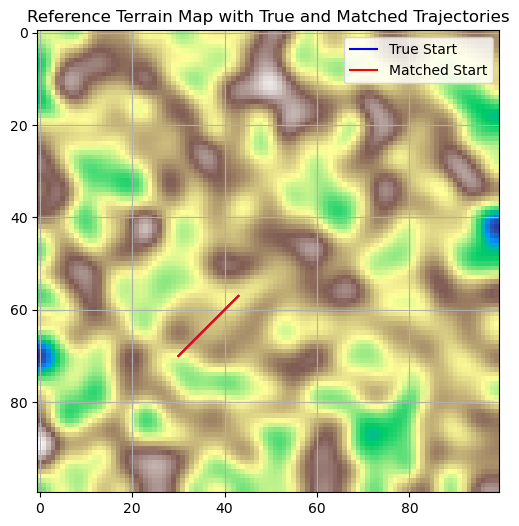

In [39]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.extract_trajectory_patch(true_start_x, true_start_y, true_heading)

# 用法二:
measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.005, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=2)

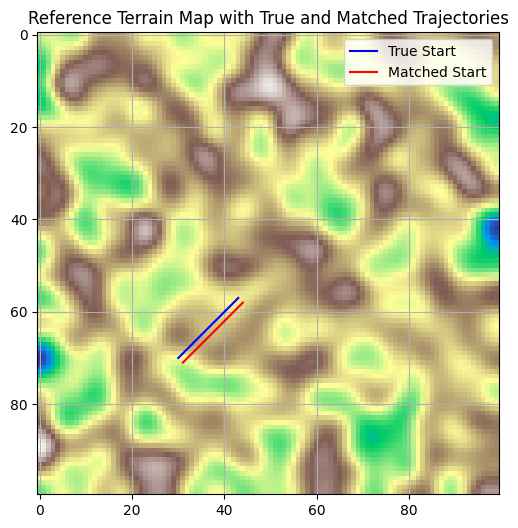

In [67]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")

#### 用法二：航向不断变换

In [40]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.gen_multi_trajectory_patch(true_start_x, true_start_y, true_heading, mode=2)


In [48]:
# 用法三:
measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.0002, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=2)

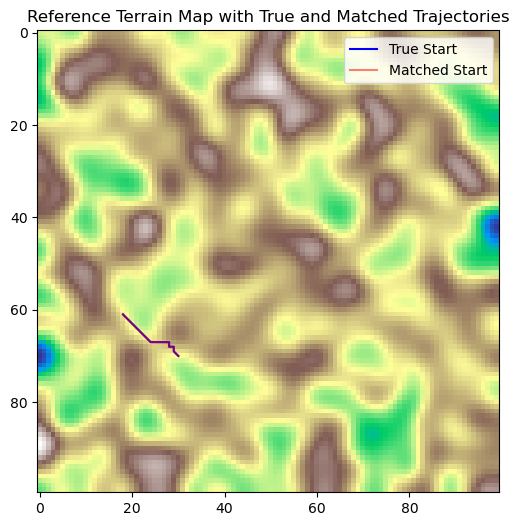

In [49]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start', alpha=0.5)
plt.legend()
#plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")

## ICCP